In [1]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
from PIL import Image
import json
from shapely import wkt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow.keras.backend as K
import keras



In [2]:
import os
# Configure paths for classification model
#xbd_dir="/content/drive/MyDrive/XBD/test/"
xbd_dir= "C:\\Users\\PC\\Desktop\\damage_assessement_data\\train"
images_dir = os.path.join(xbd_dir,"images")
labels_dir = os.path.join(xbd_dir,"labels")
classification_data = os.path.join(xbd_dir,"classification_data")
cropped_images=os.path.join(classification_data,"cropped_images")
model_save_path = os.path.join(xbd_dir,"models/")

train_csv = os.path.join(classification_data,"train.csv")
test_csv = os.path.join(classification_data,"test.csv")

os.makedirs(classification_data, exist_ok=True)
os.makedirs(cropped_images, exist_ok=True)
os.makedirs(model_save_path, exist_ok=True)

damage_labels = {0:"0", 1:"1", 2:"2", 3:"3"}
batch_size = 64
epochs = 100

In [25]:
#Crop the image to buildings
def crop_images_to_polygons(img_array, polygon_pts):
    height, width, channels = img_array.shape
    # get x and y coordinates from the polygon points
    x_coords,y_coords = polygon_pts[:, 0],polygon_pts[:, 1]
    # minimum and maximum x and y coordinates
    xmin, xmax = np.min(x_coords), np.max(x_coords)
    ymin, ymax = np.min(y_coords), np.max(y_coords)
    # differences between maximum and minimum coordinates
    xdiff, ydiff = xmax - xmin, ymax - ymin
    # extend image by 80% of the width and height
    xmin = max(int(xmin - (xdiff * 0.8)), 0)
    xmax = min(int(xmax + (xdiff * 0.8)), width)
    ymin = max(int(ymin - (ydiff * 0.8)), 0)
    ymax = min(int(ymax + (ydiff * 0.8)), height)
    # Crop the image using the co-ordinates
    return img_array[ymin:ymax, xmin:xmax, :]

In [26]:
from PIL import Image
def process_label_data(images_dir, output_path, output_csv_path):
    x_data = []
    y_data = []
    # Encode damage labels to integers
    damage_labels = { 'un-classified' : 0, 'no-damage': 0 , 'minor-damage': 1, 'major-damage': 2, 'destroyed': 3 }
    # Read Image and Label files and crop the buildings
    for image_name in os.listdir(images_dir):
        img_path = os.path.join(images_dir,image_name)
        img_obj = Image.open(img_path)
        img_array = np.array(img_obj)
        label_name = image_name.replace('.png', '.json')
        label_path = os.path.join(labels_dir,label_name)
        label_file = open(label_path)
        label_data = json.load(label_file)
        for feat in label_data['features']['xy']:
            # get the damage type and building id
            damage_type = feat['properties'].get('subtype', 'no-damage')
            poly_uid = feat['properties']['uid']
            poly_uid += ".png"
            # add the damage label to y_data
            y_data.append(damage_labels[damage_type])
            # extract building shape in wkt format from json and convert to shapely object
            building_shape = wkt.loads(feat['wkt'])
            # extract building vertices/co-ordinates from shapely object
            polygon_pts = np.array(list(building_shape.exterior.coords))
            poly_img = crop_images_to_polygons(img_array, polygon_pts)
            # save the cropped image with building_id
            cv2.imwrite(os.path.join(output_path,poly_uid), poly_img )
            # add building_id.png to x_data
            x_data.append(poly_uid)

    # Split the data into training and testing sets
    output_train_csv_path = os.path.join(output_csv_path, "train.csv")
    output_test_csv_path = os.path.join(output_csv_path, "test.csv")
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.25)
    data_array_train = {'building_id': x_train, 'damage_level': y_train}
    data_array_test = {'building_id': x_test, 'damage_level': y_test}
    # Save the train and test to CSV files
    df_train = pd.DataFrame(data_array_train)
    df_test = pd.DataFrame(data_array_test)
    df_train.to_csv(output_train_csv_path)
    df_test.to_csv(output_test_csv_path)

In [27]:
process_label_data(images_dir, cropped_images, classification_data)

In [3]:
# F1 Score
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    # Recall
    recall = true_positives / (possible_positives + K.epsilon())
    # Precision
    precision = true_positives / (predicted_positives + K.epsilon())
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [4]:
# Loss function for ordinal loss
def ordinal_loss(y_true, y_pred):
    weights = K.cast(K.abs(K.argmax(y_true, axis=1) - K.argmax(y_pred, axis=1))/(K.int_shape(y_pred)[1] - 1), dtype='float32')
    return (1.0 + weights) * keras.losses.categorical_crossentropy(y_true, y_pred )

def classification_model():
    # Define the input layer with shape (128, 128, 3)
    inputs = layers.Input(shape=(128, 128, 3))

    # ResNet50 model pre-trained on ImageNet without the top layer
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

    # Freeze the layers of the base model so they are not trainable
    for layer in base_model.layers:
        layer.trainable = False

    # convolutional layer with 32 filters, 5x5 kernel size, and ReLU activation
    x = layers.Conv2D(32, (5, 5), strides=(1, 1), padding='same', activation='relu')(inputs)
    # max pooling layer with pool size (2, 2)
    x = x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)

    # convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    # max pooling layer with pool size (2, 2)
    x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)

    # convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
    x = layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu')(x)
    # pooling layer with pool size (2, 2)
    x = x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(x)

    # Flatten the output of the convolutional layers
    x = layers.Flatten()(x)

    # Pass the input through the base ResNet50 model and flatten its output
    base_resnet = base_model(inputs)
    base_resnet = layers.Flatten()(base_resnet)

    # Concatenate the output of the convolutional layers and the output of the base ResNet50 model
    concatenated_layers = layers.Concatenate()([x, base_resnet])

    # fully connected layer with 2024 neurons and ReLU activation
    x = layers.Dense(2024, activation='relu')(concatenated_layers)
    # fully connected layer with 524 neurons and ReLU activation
    x = layers.Dense(524, activation='relu')(x)
    # dropout layer with dropout rate 0.4
    x = layers.Dropout(0.4)(x)
    # fully connected layer with 124 neurons and ReLU activation
    x = layers.Dense(124, activation='relu')(x)
    # Output layer with 4 neurons for classification and softmax activation
    output = layers.Dense(4, activation='softmax')(x)

    # model with input and output layers
    model = Model(inputs=inputs, outputs=output)

    return model

In [5]:
# Train and Validation dataset
df = pd.read_csv(train_csv)
label_classes = np.unique(df['damage_level'].to_list())
label_class_weights = class_weight.compute_class_weight(class_weight='balanced',classes= label_classes, y=df['damage_level'].to_list())
label_class_weights = dict(enumerate(label_class_weights))

num_cropped_images = df['building_id'].count()
steps = np.ceil(num_cropped_images/batch_size)

df = df.replace({"damage_level" : damage_labels})
train_gen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rescale=1/255.)
train_dataset = train_gen.flow_from_dataframe(dataframe=df,directory=cropped_images, x_col='building_id',y_col='damage_level',batch_size=64,seed=123,class_mode="categorical",target_size=(128, 128))

df = pd.read_csv(test_csv)
df = df.replace({"damage_level" : damage_labels })
valid_gen = ImageDataGenerator(rescale=1/255.)
valid_dataset = valid_gen.flow_from_dataframe(dataframe=df,directory=cropped_images,x_col='building_id',y_col='damage_level',batch_size=64,shuffle=False,seed=123,class_mode="categorical",target_size=(128, 128))

Found 244180 validated image filenames belonging to 4 classes.
Found 81394 validated image filenames belonging to 4 classes.


In [6]:
#Classification Model
model = classification_model()
#model.summary()

In [7]:
# Compile with Adam Optimizer
model.compile(loss=ordinal_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', f1])

In [8]:
#Train the classification model
from PIL import Image
history=model.fit(train_dataset,steps_per_epoch=steps,epochs=epochs,workers=4,use_multiprocessing=False,class_weight=label_class_weights,verbose=1)

#Evaluate model using validation dataset
predictions = model.predict(valid_dataset)
val_trues = valid_dataset.classes
val_pred = np.argmax(predictions, axis=-1)

f1_weighted = f1_score(val_trues, val_pred, average='weighted')
accuracy_score = accuracy_score(val_trues, val_pred)
print(f"Accuracy: {accuracy_score}")
print(f"F1_score: {f1_weighted}")

Epoch 1/100
3816/3816 [==============================] - 370s 95ms/step - loss: 1.7447 - accuracy: 0.2925 - f1: 0.1526
Epoch 2/100
3816/3816 [==============================] - 359s 94ms/step - loss: 1.5748 - accuracy: 0.2971 - f1: 0.2379
Epoch 3/100
3816/3816 [==============================] - 358s 94ms/step - loss: 1.5130 - accuracy: 0.3218 - f1: 0.2607
Epoch 4/100
3816/3816 [==============================] - 357s 94ms/step - loss: 1.4678 - accuracy: 0.3472 - f1: 0.2863
Epoch 5/100
3816/3816 [==============================] - 357s 93ms/step - loss: 1.4272 - accuracy: 0.3690 - f1: 0.3099
Epoch 6/100
3816/3816 [==============================] - 357s 94ms/step - loss: 1.4043 - accuracy: 0.3819 - f1: 0.3208
Epoch 7/100
3816/3816 [==============================] - 357s 94ms/step - loss: 1.3763 - accuracy: 0.3990 - f1: 0.3339
Epoch 8/100
3816/3816 [==============================] - 358s 94ms/step - loss: 1.3562 - accuracy: 0.4119 - f1: 0.3475
Epoch 9/100
3816/3816 [=========================

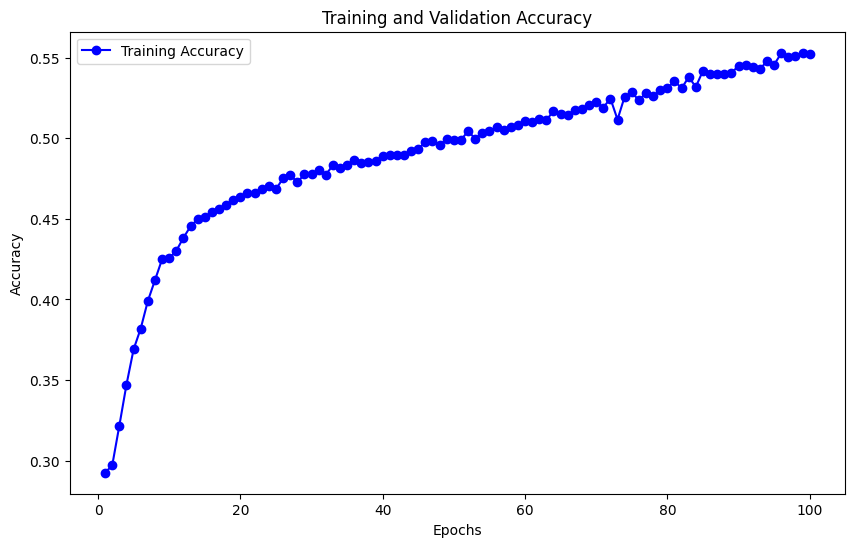

In [13]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']

# Extract number of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='Training Accuracy')
#plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')

# Adding titles and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


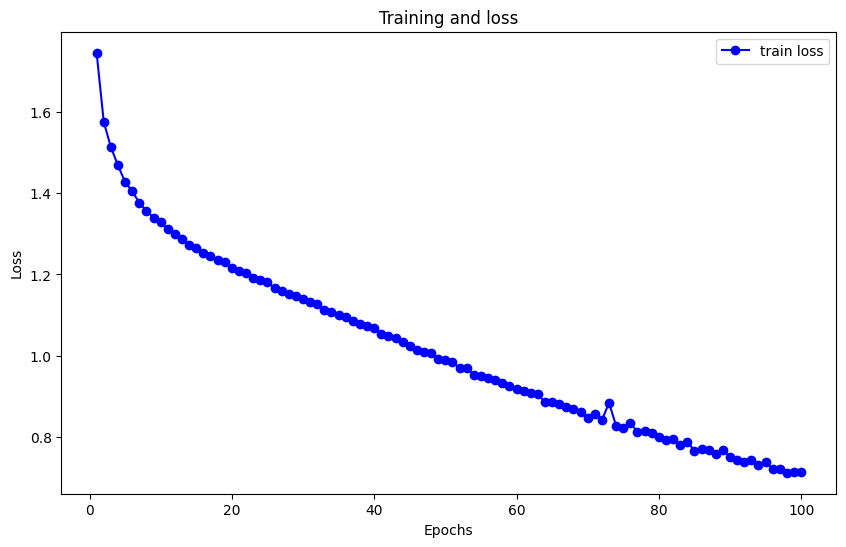

: 

In [15]:
import matplotlib.pyplot as plt

train_acc = history.history['loss']
#val_acc = history.history['val_accuracy']

# Extract number of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='train loss')
#plt.plot(epochs, val_acc, 'r*-', label='Validation Accuracy')

# Adding titles and labels
plt.title('Training and loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt

train_acc = history.history['']
#val_acc = history.history['val_f1']

# Extract number of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc, 'bo-', label='training f1 score')
plt.plot(epochs, val_acc, 'r*-', label='Validation f1 score')

# Adding titles and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plot
plt.show()


In [10]:
#Save model weights
model.save_weights(model_save_path)